## POS tagging using modified Viterbi

**Goals:** 
#####   - To use the Vanilla Viterbi algorithm for assigning POS tags (i.e. without dealing with unknown words) 
    
#####   - To Solve the problem of unknown words using at least two techniques by using modification techniques on the original vanilla Viterbi.
    
#####     - To Compare the tagging accuracy after making these modifications with the vanilla Viterbi algorithm.
    
#####     - To identify & List down at least three cases from the sample test file (i.e. unknown word-tag pairs) which were incorrectly tagged by the original Viterbi POS tagger and got corrected after your modifications.

### Data Preparation

In [1]:
#Importing libraries
import nltk
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# Checking some of the tagged data
print(nltk_data[:5])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

### Splitting into Train & Validation Sets

In [4]:
# Here we are splitting the data into training and validation set in the ratio 95:5. 
# We have named the validation set as 'test_set' over here.

random.seed(1234)

train_set, test_set = train_test_split(nltk_data, train_size=0.95, test_size=0.05)

print("Training Set Length -", len(train_set))
print("Testing Set Length -", len(test_set))
print("-" * 100)
print("Training Data -\n")
print(train_set[:10])

Training Set Length - 3718
Testing Set Length - 196
----------------------------------------------------------------------------------------------------
Training Data -

[[('Another', 'DET'), ('concern', 'NOUN'), (':', '.'), ('The', 'DET'), ('funds', 'NOUN'), ("'", 'PRT'), ('share', 'NOUN'), ('prices', 'NOUN'), ('tend', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('swing', 'VERB'), ('more', 'ADV'), ('than', 'ADP'), ('the', 'DET'), ('broader', 'ADJ'), ('market', 'NOUN'), ('.', '.')], [('U.S.', 'NOUN'), ('trade', 'NOUN'), ('negotiators', 'NOUN'), ('argue', 'VERB'), ('that', 'ADP'), ('countries', 'NOUN'), ('with', 'ADP'), ('inadequate', 'ADJ'), ('protections', 'NOUN'), ('for', 'ADP'), ('intellectual-property', 'ADJ'), ('rights', 'NOUN'), ('could', 'VERB'), ('be', 'VERB'), ('hurting', 'VERB'), ('themselves', 'PRON'), ('by', 'ADP'), ('*-1', 'X'), ('discouraging', 'VERB'), ('their', 'PRON'), ('own', 'ADJ'), ('scientists', 'NOUN'), ('and', 'CONJ'), ('authors', 'NOUN'), ('and', 'CONJ'), ('by', 'ADP'

In [5]:
# Check the list of tagged words in the training data i.e 'train_set'

train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95646

In [6]:
# Lets check some of the train_tagged words

train_tagged_words[:10]

[('Another', 'DET'),
 ('concern', 'NOUN'),
 (':', '.'),
 ('The', 'DET'),
 ('funds', 'NOUN'),
 ("'", 'PRT'),
 ('share', 'NOUN'),
 ('prices', 'NOUN'),
 ('tend', 'VERB'),
 ('*-1', 'X')]

In [7]:
test_tagged_words = [tup[0] for sent in test_set for tup in sent]
print("Train Tagged Words - ", len(test_tagged_words))

Train Tagged Words -  5030


In [8]:
# tokens in the train set - train_tagged_words
train_tagged_tokens = [tag[0] for tag in train_tagged_words]
train_tagged_tokens[:10]

['Another',
 'concern',
 ':',
 'The',
 'funds',
 "'",
 'share',
 'prices',
 'tend',
 '*-1']

In [9]:
# POS tags for the tokens in the train ser:

train_data_pos_tags = [pair[1] for pair in train_tagged_words]
train_data_pos_tags[:10]

['DET', 'NOUN', '.', 'DET', 'NOUN', 'PRT', 'NOUN', 'NOUN', 'VERB', 'X']

In [10]:
# building the train vocabulary to a set
training_vocabulary_set = set(train_tagged_tokens)

In [11]:
# building the POS tags to a set
training_pos_tag_set = set(train_data_pos_tags)

In [12]:
# let's check how many unique tags are present in training data
print(len(training_pos_tag_set))

12


In [13]:
# let's check how many words are present in vocabulary
print(len(training_vocabulary_set))

12028


### Building the Vanilla Viterbi based POS tagger

Plain HMM-based POS tagger is built using the Viterbi Heuristic and the performance is evaluated on the validation dataset.

Before proceeding for the Viterbi Heuristic we write methods to calculate:

1- Transition Probabilities
2- Emission Probabilities

####  Emission Probabilities Computation Method

In [14]:
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1] == tag]
    tag_count = len(tag_list)    
    word_given_tag_list = [pair[0] for pair in tag_list if pair[0] == word]    
    word_given_tag_count = len(word_given_tag_list)    
    
    return (word_given_tag_count, tag_count)

####  Transition Probabilities Computation Method

In [15]:
# Method to compute the transition probabilities of the previous and next tag
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    
    t1_tags_list = [tag for tag in tags if tag == t1]
    t1_tags_count = len(t1_tags_list)
    
    t2_given_t1_list = [tags[index+1] for index in range(len(tags)-1) if tags[index] == t1 and tags[index+1] == t2]
    t2_given_t1_count = len(t2_given_t1_list)
    
    return(t2_given_t1_count, t1_tags_count)

#### Transition Matrix   
    
    -First we compute the P(w/t) and store it in [Tags x Vocabulary] matrix of dimension of len(training_pos_tag_set) X en(training_vocabulary_set)
    
    -Next we create 't x t' transition matrix called as 'tags_matrix' of training_pos_tag_set   
    
    -Also the matrix is converted to a dataframe for better readability as below.

In [16]:
len_pos_tags = len(training_pos_tag_set)
len_vocab = len(training_vocabulary_set)

In [17]:
# Each column is t2, each row is t1, thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len_pos_tags, len_pos_tags), dtype='float32')
for i, t1 in enumerate(list(training_pos_tag_set)):
    for j, t2 in enumerate(list(training_pos_tag_set)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [18]:
tags_df = pd.DataFrame(tags_matrix, columns = list(training_pos_tag_set), index=list(training_pos_tag_set))

In [19]:
tags_df

,DET,VERB,PRON,ADV,ADJ,PRT,CONJ,X,NOUN,ADP,NUM,.
DET,0.005424,0.040497,0.003736,0.013017,0.205134,0.000241,0.000482,0.046161,0.636013,0.009280,0.022659,0.017356
VERB,0.133560,0.169304,0.035745,0.081526,0.064695,0.031576,0.005481,0.217633,0.110631,0.091639,0.023083,0.035127
PRON,0.009985,0.487711,0.007296,0.034178,0.072197,0.011905,0.004992,0.092550,0.208525,0.023425,0.007296,0.039939
ADV,0.068520,0.344257,0.015558,0.079775,0.128765,0.014234,0.007613,0.023171,0.031778,0.118835,0.031447,0.136048
ADJ,0.004912,0.011790,0.000655,0.004421,0.067627,0.010480,0.016702,0.020796,0.698870,0.077452,0.021287,0.065007
PRT,0.100000,0.403583,0.017590,0.010098,0.084365,0.001303,0.002280,0.013355,0.245928,0.020847,0.057003,0.043648
CONJ,0.119202,0.158163,0.058442,0.056122,0.118275,0.004638,0.000464,0.008349,0.346475,0.054731,0.041744,0.033395
X,0.054170,0.205083,0.055123,0.025735,0.017156,0.186815,0.010326,0.074186,0.061477,0.143924,0.002859,0.163145
NOUN,0.013501,0.147744,0.004720,0.017050,0.012111,0.044016,0.042699,0.029527,0.263181,0.177125,0.009476,0.238850
ADP,0.325718,0.008434,0.067898,0.013665,0.107505,0.001388,0.000747,0.033629,0.321768,0.017295,0.062133,0.039821


### EXPLORATORY DATA ANALYSIS 

    -Here for EDA purpose heatmap of tags matrix is created and analysed.
    
    -NOTE:  T(i, j) means P(tag j given tag i)

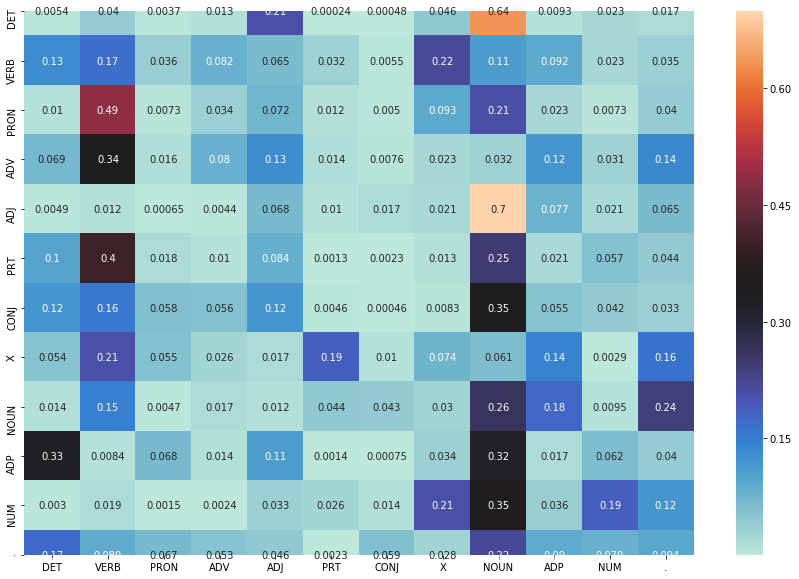

In [20]:
plt.figure(figsize=(15, 10))
sns.heatmap(tags_df, annot = True,cmap="icefire")
plt.show()

In [21]:
#Checking the frequent tags 

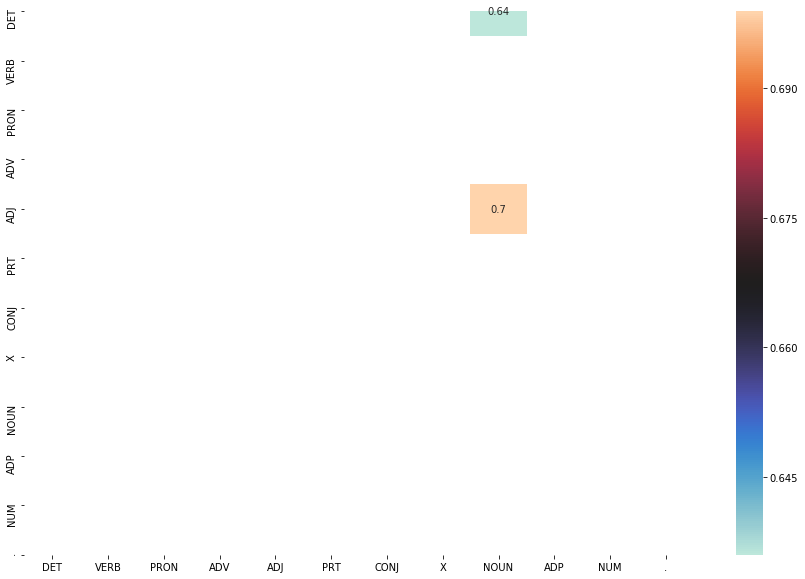

In [22]:
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(15, 10))
sns.heatmap(tags_frequent, annot = True,cmap="icefire")
plt.show()

## Build the Vanilla Viterbi based POS tagger

### Vanilla Viterbi Heuristic Method

In [23]:
def Vanilla_Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

#### Testing Vanilla Viterbi Algorithm on sampled test data

    1- First we create a list of tagged words
    2- Then we create a list of untagged words
    3- The test sequences are tagged using Vanilla Viterbi method
    4- Then we check the accuracy using vanilla viterbi method
    5- Also the number of total incorrect tagged words are checked

In [24]:
random.seed(1234)

# list of tagged words
test_run_base = [tup for sent in test_set for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_set for tup in sent]

In [25]:
# tagging the test sentences

tagged_seq = Vanilla_Viterbi(test_tagged_words)

In [26]:
# Checking the accuracy 

check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]

vanilla_viterbi_accuracy = len(check)/len(tagged_seq)

print("The Accuracy of the Vanilla Viterbi Algorithm is : ", vanilla_viterbi_accuracy)

The Accuracy of the Vanilla Viterbi Algorithm is :  0.8958250497017892


In [27]:
# checking the incorrectly tagged words
incorrect_tagged_words = [j for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]]

print("Total Incorrect Tagged Words :", len(incorrect_tagged_words))
print("\n")
print("Incorrectly Tagged Words are as follow : \n" + "\n", incorrect_tagged_words)

Total Incorrect Tagged Words : 524


Incorrectly Tagged Words are as follow : 

 [(('definitive', 'DET'), ('definitive', 'ADJ')), (('ancestry', 'DET'), ('ancestry', 'NOUN')), (('born', 'DET'), ('born', 'VERB')), (('Puerto', 'DET'), ('Puerto', 'NOUN')), (('Rico', 'DET'), ('Rico', 'NOUN')), (('much', 'ADV'), ('much', 'ADJ')), (('print', 'VERB'), ('print', 'NOUN')), (('FAX', 'DET'), ('FAX', 'NOUN')), (('more', 'ADV'), ('more', 'ADJ')), (('open', 'VERB'), ('open', 'ADJ')), (('blue-chips', 'DET'), ('blue-chips', 'NOUN')), (('bearing', 'NOUN'), ('bearing', 'VERB')), (('brunt', 'DET'), ('brunt', 'NOUN')), (('steal', 'DET'), ('steal', 'VERB')), (('discordant', 'DET'), ('discordant', 'ADJ')), (('*-135', 'DET'), ('*-135', 'X')), (('church-goers', 'DET'), ('church-goers', 'NOUN')), (('enjoying', 'DET'), ('enjoying', 'VERB')), (('cool', 'DET'), ('cool', 'ADJ')), (('7.79', 'DET'), ('7.79', 'NUM')), (('7.52', 'DET'), ('7.52', 'NUM')), (('7.60', 'DET'), ('7.60', 'NUM')), (('oversight', 'DET'), ('over

### Checking for Unknown words

Unknown words are those words that are present in the test set but not in the train set. Basically these are the  words the algorithm has not seen before in its corpus before.

In [28]:
# Finding the Unknown words 

test_vocabulary_set = set([t for t in test_tagged_words])

unknown_words = list(test_vocabulary_set - training_vocabulary_set)
print("Total Unknown words :", len(unknown_words))

Total Unknown words : 380


In [29]:
print("Unknown Words List : \n", unknown_words)

Unknown Words List : 
 ['107.03', 'hobbyists', 'TREASURY', 'Macheski', 'Auditors', '422.5', 'signboards', 'crookery', 'Lighthouse', 'marbles', 'reopened', 'reaped', 'robotic', 'hoopla', 'dismay', 'taxpayer', 'sogo-shosha', 'needle-like', 'Palisades', 'abuzz', '*T*-113', 'compatible', 'gauging', 'Toys', 'introduces', 'appropriate', 'Signet', '45.2', '18-year-old', 'species', '*-164', 'Puerto', 'glamorize', 'count', '*T*-93', 'erroneous', 'learning', 'Duluth', 'touted', '*-125', 'Westborough', 'Brooke', 'Silicon', 'smooth', 'Areas', '*T*-228', 'stalls', 'notify', 'Vermont', '*T*-200', '1,050,000', '154.2', 'Longwood', 'repriced', 'convinced', 'Bucking', 'Jalaalwalikraam', 'obsessed', 'ingenuity', 'predicated', 'desperately', 'categories', 'Huber', 'legislature', 'Yorker', '1.24', 'succession', 'hegemony', 'Hours', 'Piero', 'TRUST', '*-119', 'O.', 'subskills', 'amphobiles', 'cards', '30-point', 'oils', 'fearful', 'ASSETS', 'ROGERS', 'Wilton', 'kits', 'emerged', '500-Stock', '66.5', 'Norwi

#### Observation of Vanilla Viterbi Method :

    The default Vanilla viterbi algorithm achieved an accuracy of about 89.6% 

    Approx. 11% loss of accuracy was majorly due to the fact that when the algorithm encountered an unknown word (i.e. not present in the training set), it assigned an incorrect tag arbitrarily. 
    
    This is because, for unknown words, the emission probabilities for all candidate tags are 0, so the algorithm arbitrarily chooses (the first) tag.

    Now we try to minimize this loss by modifying the vanilla viterbi.

## Solve the problem of unknown words


### Method 1: Viterbi Modification-Technique I - Vanilla_Viterbi_for_Unknown_Words

    If a word is not present in the training vocabulary (unknown word), its emission probability will be 0.In that case the state probability will inturn be zero. Thus in cases where the algorithm encounters a word which it has not see previously, we can omit the emission probability and only consider the transition probability.

    The algorithm can be modified to deal the case as below - 

    **If word in unknown then: <br></br><br></br>
    consider only the transition_p (emission probability being 0)<br></br><br></br>
    else:<br></br><br></br>
       consider both the emission and transition probability.**

In [30]:
# Modified Viterbi Heuristic
def Vanilla_Viterbi_for_Unknown_Words(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
            # modification to the original vanilla viterbi algorithm to consider unknown words
            if word not in training_vocabulary_set:
                state_probability = transition_p
            else:
                state_probability = emission_p * transition_p
                
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [31]:
# tagging the test sentences
unknown_word_tagged_seq = Vanilla_Viterbi_for_Unknown_Words(test_tagged_words)

# accuracy
unknown_word_check = [i for i, j in zip(unknown_word_tagged_seq, test_run_base) if i == j]

optimized_viterbi_accuracy = len(unknown_word_check)/len(unknown_word_tagged_seq)

print("The accuracy of the Vanilla Viterbi Algorithm after modification to handle unknown words is -", optimized_viterbi_accuracy)

The accuracy of the Vanilla Viterbi Algorithm after modification to handle unknown words is - 0.9371769383697813


#### Observation of Modified Viterbi Method - I :

    The modified viterbi achieves an accuracy of (approx.) 93.7%. Earlier the default Vanilla viterbi algorithm achieved an accuracy of about 89.6%. 
    Hence the modified viterbi algorithm performs better than the original vanilla viterbi algorithm.  Still a loss of approx. 6-7% is seen.
    Now we try to reduce this loss further.


### Let's try with some Lexicon and Rule-Based Models for POS Tagging.


#### 1.Unigram Tagger

In [32]:
# Unigram Tagger

unigram_tagger = nltk.UnigramTagger(train_set)
unigram_tagger_accuracy = unigram_tagger.evaluate(test_set)
print("The accuracy of the Unigram Tagger is -", unigram_tagger_accuracy)

The accuracy of the Unigram Tagger is - 0.894831013916501


#### 2. Rule based RegexpTagger

In [33]:
#Let's now try combining the unigram tagger with a rule based regex tagger.

# patterns for tagging using a rule based regex tagger -

patterns = [
    (r'^[aA-zZ].*[0-9]+','NOUN'),  # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*', 'NOUN'),    
    (r'.*ly$', 'ADV'),
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'), # modals
    (r'(The|the|A|a|An|an)$', 'DET'),
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), # adjective like 100-megabytes 237-Seats
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb
    (r'[0-9].?[,\/]?[0-9]*','NUM')# Numbers 
    ]

In [34]:
rule_based_tagger = nltk.RegexpTagger(patterns)

# unigram tagger backed up by the rule-based tagger
rule_based_unigram_tagger = nltk.UnigramTagger(train_set, backoff = rule_based_tagger)

accuracy_rule_based_unigram_tagger = rule_based_unigram_tagger.evaluate(test_set)

print("The accuracy of the Unigram Tagger backed up by the RegexpTagger is -", accuracy_rule_based_unigram_tagger)

The accuracy of the Unigram Tagger backed up by the RegexpTagger is - 0.9377733598409542


#### 3.Bigram tagger

In [35]:
bigram_tagger = nltk.BigramTagger(train_set, backoff = rule_based_unigram_tagger)
bigram_tagger.evaluate(test_set)
accuracy_bigram_tagger = bigram_tagger.evaluate(test_set)
print("The accuracy of the Bigram Tagger backed up by the rule_based_unigram_tagger is -", accuracy_bigram_tagger)

The accuracy of the Bigram Tagger backed up by the rule_based_unigram_tagger is - 0.9415506958250497


#### 4.Trigram tagger

In [36]:
trigram_tagger = nltk.TrigramTagger(train_set, backoff = bigram_tagger)
trigram_tagger.evaluate(test_set)
accuracy_trigram_tagger = trigram_tagger.evaluate(test_set)
print("The accuracy of the Trigram Tagger backed up by the bigram_tagger is -", accuracy_trigram_tagger)

The accuracy of the Trigram Tagger backed up by the bigram_tagger is - 0.9395626242544731


#### Observations:    
    -We see that the Trigram Tagger backed up by the bigram tagger gives an accuracy of 94% approximately. 
    -So now we try to modify the Viterbi Algorithm to use this trigram tagger as a back-off.



### Method 2: Viterbi Modification-Technique II : Viterbi_backedup_by_trigram_tagger

When the viterbi algorithm is not able to tag an unknown word, it uses the rule-based tagger.

In [75]:
#A trigram tagger backed off by a rule based tagger.

def trigram_tagger(word, train_set = train_set):
    
    patterns = [
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb

    (r'.*ly$', 'ADV'),
        
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), 
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
        
    (r'^[aA-zZ].*[0-9]+','NOUN'),     # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns - words ending with 's
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*ers$', 'NOUN'),              # eg.- kinderganteners, autobioghapgers
    (r'.*ment$', 'NOUN'),
    (r'.*town$', 'NOUN'),
        
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'),
        
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # That/this/these/those belong to the category of Demonstrative determiners
    (r'[0-9].?[,\/]?[0-9]*','NUM'), # Numbers 
        
    (r'.*', 'NOUN')
    ]

    regex_based_tagger = nltk.RegexpTagger(patterns)

    # trigram backed up by the regex tagger
    trigram_regex_tagger = nltk.TrigramTagger(train_set, backoff = regex_based_tagger)
    return trigram_regex_tagger.tag_sents([[(word)]])

In [76]:
def viterbi_backedup_by_trigram_tagger(words, train_bag = train_tagged_words):
    state = []
    tag_set = list(set([pair[1] for pair in train_bag]))
    
    # use the trigram tagger backed up by the rule based tagger for unknown words.
    for key, word in enumerate(words):
        if word not in training_vocabulary_set:
            unknown_word_tag = trigram_tagger(word)
            for sent in unknown_word_tag:
                for tup in sent:
                    state.append(tup[1])
        else:            
            p = [] 
            for tag in tag_set:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = tag_set[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))

In [39]:
# tagging the test sentences
viterbi_trigram_tagged_seq = viterbi_backedup_by_trigram_tagger(test_tagged_words)

# accuracy
viterbi_trigram_word_check = [i for i, j in zip(viterbi_trigram_tagged_seq, test_run_base) if i == j]

viterbi_trigram_accuracy = len(viterbi_trigram_word_check)/len(viterbi_trigram_tagged_seq)

print("The accuracy of the viterbi_backedup_by_trigram_tagger is -", viterbi_trigram_accuracy)

The accuracy of the viterbi_backedup_by_trigram_tagger is - 0.9614314115308151


#### Observation of Modified Viterbi Method - II(backed by Trigram Tagger) :

        The modified viterbi backed by trigram tagger achieves an accuracy of (approx.) 96.14% which is comparatively higher than the other two methods. Earlier the default Vanilla viterbi algorithm achieved an accuracy of about 89.6% & Modified Viterbi I method achieved an accuracy of 93.72%.

## Evaluating tagging accuracy

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

Lets compare the accuracy obtained from each algorithm and draw a graph to compare the same.

In [40]:
acccuracy_data = [['Vanilla Viterbi', vanilla_viterbi_accuracy * 100], 
                  ['Vanilla Viterbi Modified', optimized_viterbi_accuracy*100 ], 
                  ['Unigram Tagger', unigram_tagger_accuracy * 100],
                  ['Unigram + RegexpTagger', accuracy_rule_based_unigram_tagger * 100],
                  ['Bigram Tagger + Unigram_tagger', accuracy_bigram_tagger*100],
                  ['Trigram Tagger + Bigram_tagger', accuracy_trigram_tagger*100],
                  ['Viterbi + Trigram_tagger', viterbi_trigram_accuracy*100]]

acccuracy_data_df = pd.DataFrame(acccuracy_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

acccuracy_data_df.set_index('Tagging_Algorithm', drop = True, inplace = True)

acccuracy_data_df

,Tagging_Accuracy
Tagging_Algorithm,
Vanilla Viterbi,89.582505
Vanilla Viterbi Modified,93.717694
Unigram Tagger,89.483101
Unigram + RegexpTagger,93.777336
Bigram Tagger + Unigram_tagger,94.155070
Trigram Tagger + Bigram_tagger,93.956262
Viterbi + Trigram_tagger,96.143141


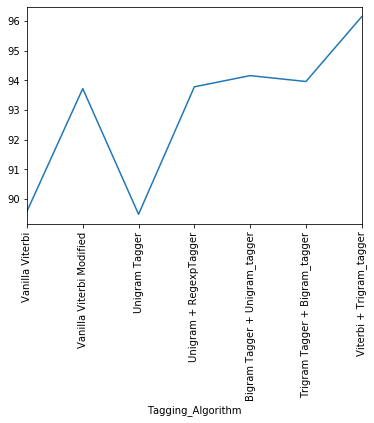

In [41]:
acccuracy_data_df.plot.line(rot = 90, legend = False)

#### Observation

    Based on the calculated and plooted observations of accuracy of each method we can say that ViterbiAlgorithm backed by Trigram Tagger has the highest accuracy and Unigram has the lowest accuracy. That means the modified Viterbi Algorithm backed by Trigram tagger should make more accurate predictions of the worda & tags as compared to the other methods. 

### 2. Next, lets check the tagging accuracies for the algorithm on the sample test sentences provided -

In [42]:
sample_test_sentences = ["Android is a mobile operating system developed by Google.",
"Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.",
"Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
"Twitter is an online news and social networking service on which users post and interact with messages known as tweets.",
"Before entering politics, Donald Trump was a domineering businessman and a television personality.",
"The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.",
"This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.",
"Show me the cheapest round trips from Dallas to Atlanta",
"I would like to see flights from Denver to Philadelphia.",
"Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.",
"NASA invited social media users to experience the launch of ICESAT-2 Satellite."]

In [43]:
sample_test_tokenized_sents = [word_tokenize(sent) for sent in sample_test_sentences]
sample_test_corpus_pos_tags = nltk.pos_tag_sents(sample_test_tokenized_sents, tagset = 'universal')
sample_test_corpus_pos_tags

[[('Android', 'NOUN'),
  ('is', 'VERB'),
  ('a', 'DET'),
  ('mobile', 'ADJ'),
  ('operating', 'NOUN'),
  ('system', 'NOUN'),
  ('developed', 'VERB'),
  ('by', 'ADP'),
  ('Google', 'NOUN'),
  ('.', '.')],
 [('Android', 'NOUN'),
  ('has', 'VERB'),
  ('been', 'VERB'),
  ('the', 'DET'),
  ('best-selling', 'ADJ'),
  ('OS', 'NOUN'),
  ('worldwide', 'NOUN'),
  ('on', 'ADP'),
  ('smartphones', 'NOUN'),
  ('since', 'ADP'),
  ('2011', 'NUM'),
  ('and', 'CONJ'),
  ('on', 'ADP'),
  ('tablets', 'NOUN'),
  ('since', 'ADP'),
  ('2013', 'NUM'),
  ('.', '.')],
 [('Google', 'NOUN'),
  ('and', 'CONJ'),
  ('Twitter', 'NOUN'),
  ('made', 'VERB'),
  ('a', 'DET'),
  ('deal', 'NOUN'),
  ('in', 'ADP'),
  ('2015', 'NUM'),
  ('that', 'DET'),
  ('gave', 'VERB'),
  ('Google', 'NOUN'),
  ('access', 'NOUN'),
  ('to', 'PRT'),
  ('Twitter', 'NOUN'),
  ("'s", 'PRT'),
  ('firehose', 'NOUN'),
  ('.', '.')],
 [('Twitter', 'NOUN'),
  ('is', 'VERB'),
  ('an', 'DET'),
  ('online', 'ADJ'),
  ('news', 'NOUN'),
  ('and', 'CONJ'

In [44]:
# list of untagged words from the sample test data provided
sample_test_tagged_words = [tup[0] for sent in sample_test_corpus_pos_tags for tup in sent]


# list of tagged words
sample_test_test_run_base = [tup for sent in sample_test_corpus_pos_tags for tup in sent]

In [45]:
sample_test_tagged_words

['Android',
 'is',
 'a',
 'mobile',
 'operating',
 'system',
 'developed',
 'by',
 'Google',
 '.',
 'Android',
 'has',
 'been',
 'the',
 'best-selling',
 'OS',
 'worldwide',
 'on',
 'smartphones',
 'since',
 '2011',
 'and',
 'on',
 'tablets',
 'since',
 '2013',
 '.',
 'Google',
 'and',
 'Twitter',
 'made',
 'a',
 'deal',
 'in',
 '2015',
 'that',
 'gave',
 'Google',
 'access',
 'to',
 'Twitter',
 "'s",
 'firehose',
 '.',
 'Twitter',
 'is',
 'an',
 'online',
 'news',
 'and',
 'social',
 'networking',
 'service',
 'on',
 'which',
 'users',
 'post',
 'and',
 'interact',
 'with',
 'messages',
 'known',
 'as',
 'tweets',
 '.',
 'Before',
 'entering',
 'politics',
 ',',
 'Donald',
 'Trump',
 'was',
 'a',
 'domineering',
 'businessman',
 'and',
 'a',
 'television',
 'personality',
 '.',
 'The',
 '2018',
 'FIFA',
 'World',
 'Cup',
 'is',
 'the',
 '21st',
 'FIFA',
 'World',
 'Cup',
 ',',
 'an',
 'international',
 'football',
 'tournament',
 'contested',
 'once',
 'every',
 'four',
 'years',
 '.'

### 1. Testing the accuracy of Vanilla Viterbi on sample test data - 

In [46]:
# tagging the test sentences
sample_test_tagged_seq = Vanilla_Viterbi(sample_test_tagged_words)

# Let's check the accuracy of the vanilla viterbi algorithm
sample_test_check = [i for i, j in zip(sample_test_tagged_seq, sample_test_test_run_base) if i == j]

vanilla_viterbi_accuracy_on_sample_test_data = len(sample_test_check)/len(sample_test_tagged_seq)

print("The accuracy of the Vanilla Viterbi Algorithm on the sample test data is -", vanilla_viterbi_accuracy_on_sample_test_data)

The accuracy of the Vanilla Viterbi Algorithm on the sample test data is - 0.7513812154696132


### 2. Testing the accuracy of Vanilla_Viterbi_for_Unknown_Words on sample test data - 

In [47]:
# tagging the test sentences
sample_test_unknown_word_tagged_seq = Vanilla_Viterbi_for_Unknown_Words(sample_test_tagged_words)

# accuracy
sample_test_unknown_word_check = [i for i, j in zip(sample_test_unknown_word_tagged_seq, sample_test_test_run_base) if i == j]

sample_test_optimized_viterbi_accuracy = len(sample_test_unknown_word_check)/len(sample_test_unknown_word_tagged_seq)

print("The accuracy of the Vanilla_Viterbi_for_Unknown_Words on the sample test data is -", sample_test_optimized_viterbi_accuracy)

The accuracy of the Vanilla_Viterbi_for_Unknown_Words on the sample test data is - 0.861878453038674


### 3. Testing the accuracy of Viterbi_backedup_by_trigram_tagger on sample test data - 

In [48]:
# tagging the test sentences
sample_test_viterbi_trigram_tagged_seq = viterbi_backedup_by_trigram_tagger(sample_test_tagged_words)

# accuracy
sample_test_viterbi_trigram_check = [i for i, j in zip(sample_test_viterbi_trigram_tagged_seq, sample_test_test_run_base) if i == j]

sample_test_viterbi_trigram_accuracy = len(sample_test_viterbi_trigram_check)/len(sample_test_viterbi_trigram_tagged_seq)

print("The accuracy of the viterbi_backedup_by_trigram_tagger on the sample test data is -", sample_test_viterbi_trigram_accuracy)

The accuracy of the viterbi_backedup_by_trigram_tagger on the sample test data is - 0.9281767955801105


###### Comparing the accuracies of the 3 algorithm on sample test data -

In [49]:
acccuracy_on_sample_test_data = [['Vanilla Viterbi', vanilla_viterbi_accuracy_on_sample_test_data*100], 
                  ['Optimized Vanilla Viterbi', sample_test_optimized_viterbi_accuracy*100], 
                  ['Viterbi + Trigram_tagger', sample_test_viterbi_trigram_accuracy*100]]

sample_test_data_acccuracy_df = pd.DataFrame(acccuracy_on_sample_test_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

sample_test_data_acccuracy_df.set_index('Tagging_Algorithm', drop = True, inplace = True)

sample_test_data_acccuracy_df

,Tagging_Accuracy
Tagging_Algorithm,
Vanilla Viterbi,75.138122
Optimized Vanilla Viterbi,86.187845
Viterbi + Trigram_tagger,92.817680


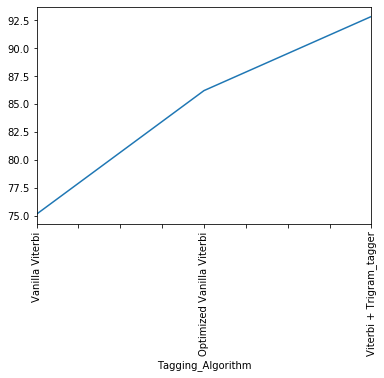

In [50]:
sample_test_data_acccuracy_df.plot.line(rot = 90, legend = False)

#### Observations:

    We can see here the accuracy of each of the algorithm on sample test data as below:	
        1- Vanilla Viterbi	- 75.14%
        2- Modified Vanilla Viterbi I - 86.2%
        3- Modified Vanilla Viterbi II(Viterbi Backedby Trigram_tagger)	- 92.82%
        
Since Modified Vanilla Viterbi II(Viterbi Backedby Trigram_tagger)is clearly the winner as it has the highest accuracy compared to the other two methods

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

    - In this task , we have considere some sample sentences as given to us and tried to correctly identify the incorrectly tagged POS Tags of Vanilla Viterbi using Modified Vanilla Viterbi

    - Below 5 such cases have been listed along with the observation of correctly identified POS tags.

    - Also a comparison of tags(using all the three methodsi.e - vanilla viterbi, modified viterbi I, modified viterbi II) for all the samples is done at the end.

In [51]:
# test sentences
test_sentence_1 = 'Android is a mobile operating system developed by Google.'
test_sentence_2 = 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'
test_sentence_3 = "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose."
test_sentence_4 = 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.'
test_sentence_5 = 'Before entering politics, Donald Trump was a domineering businessman and a television personality.'
test_sentence_6 = 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.'
test_sentence_7 = 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.'
test_sentence_8 = 'Show me the cheapest round trips from Dallas to Atlanta'
test_sentence_9 = 'I would like to see flights from Denver to Philadelphia.'
test_sentence_10 = 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.'
test_sentence_11 = 'NASA invited social media users to experience the launch of ICESAT-2 Satellite.'

#### Here we have considered some sentences from the above sampe sentences which were incorrectly tagged POS words using Vanilla Viterbi & have got correctly tagged after applying the modified viterbi technique backed by trigram tagged in our case

### Case 1 : 

**test_sentence_2 = 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'**

In [54]:
words_test_sentence_2 = nltk.word_tokenize(test_sentence_2)

# pos tags with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi = Vanilla_Viterbi(words_test_sentence_2)
print("Tagging sequence with Vanilla_Viterbi -\n\n", pos_tagged_sequence_with_vanilla_viterbi)

print('\n')
print('-'*120)

# pos tags with viterbi_backedup_by_trigram_tagger
pos_tagged_sequence_with_viterbi_trigram = viterbi_backedup_by_trigram_tagger(words_test_sentence_2)
print("Tagging sequence with viterbi_backedup_by_trigram_tagger -\n\n", pos_tagged_sequence_with_viterbi_trigram)

Tagging sequence with Vanilla_Viterbi -

 [('Android', 'DET'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'DET'), ('worldwide', 'DET'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.')]


------------------------------------------------------------------------------------------------------------------------
Tagging sequence with viterbi_backedup_by_trigram_tagger -

 [('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]


In [55]:
cols = ['vanilla_viterbi_tags', 'viterbi_trigram_tags_with_corrections']
tags_correction_df_2 = pd.DataFrame(columns = cols)
tags_correction_df_2 = tags_correction_df_2.fillna(0)

tags_correction_df_2.vanilla_viterbi_tags = [tup for tup in pos_tagged_sequence_with_vanilla_viterbi]
tags_correction_df_2.viterbi_trigram_tags_with_corrections = [tup for tup in pos_tagged_sequence_with_viterbi_trigram]

tags_correction_df_2

,vanilla_viterbi_tags,viterbi_trigram_tags_with_corrections
0,"(Android, DET)","(Android, NOUN)"
1,"(has, VERB)","(has, VERB)"
2,"(been, VERB)","(been, VERB)"
3,"(the, DET)","(the, DET)"
4,"(best-selling, ADJ)","(best-selling, ADJ)"
5,"(OS, DET)","(OS, NOUN)"
6,"(worldwide, DET)","(worldwide, NOUN)"
7,"(on, ADP)","(on, ADP)"
8,"(smartphones, DET)","(smartphones, VERB)"
9,"(since, ADP)","(since, ADP)"


#### Observation : The Incorrectly tagged words that are tagged correctly identified in the sentence 2 are as listed below:

    1- (2013, DET)-->(2013, NUM)    
    2- (smartphones, DET)-->(smartphones, VERB)   
    3- (2011, DET)-->(2011, NUM)
    4- (Android, DET)-->(Android, NOUN)
    5- (OS, DET)-->(OS, DET)
    6- (Android, DET)-->(Android, NOUN)

### Case 2:

#### test_sentence_3 = "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose."


In [56]:
# test_sentence_3 = "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose."

words_test_sentence_3 = nltk.word_tokenize(test_sentence_3)

# pos tags with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi = Vanilla_Viterbi(words_test_sentence_3)
print("Tagging sequence with Vanilla_Viterbi -\n\n", pos_tagged_sequence_with_vanilla_viterbi)

print('\n')
print('-'*100)

# pos tags with viterbi_backedup_by_trigram_tagger
pos_tagged_sequence_with_viterbi_trigram = viterbi_backedup_by_trigram_tagger(words_test_sentence_3)
print("Tagging sequence with viterbi_backedup_by_trigram_tagger -\n\n", pos_tagged_sequence_with_viterbi_trigram)

Tagging sequence with Vanilla_Viterbi -

 [('Google', 'DET'), ('and', 'CONJ'), ('Twitter', 'DET'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'DET'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'DET'), ("'s", 'VERB'), ('firehose', 'DET'), ('.', '.')]


----------------------------------------------------------------------------------------------------
Tagging sequence with viterbi_backedup_by_trigram_tagger -

 [('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')]


In [57]:
cols = ['vanilla_viterbi_tags', 'viterbi_trigram_tags_with_corrections']
tags_correction_df_3 = pd.DataFrame(columns = cols)
tags_correction_df_3 = tags_correction_df_3.fillna(0)

tags_correction_df_3.vanilla_viterbi_tags = [tup for tup in pos_tagged_sequence_with_vanilla_viterbi]
tags_correction_df_3.viterbi_trigram_tags_with_corrections = [tup for tup in pos_tagged_sequence_with_viterbi_trigram]

tags_correction_df_3

,vanilla_viterbi_tags,viterbi_trigram_tags_with_corrections
0,"(Google, DET)","(Google, NOUN)"
1,"(and, CONJ)","(and, CONJ)"
2,"(Twitter, DET)","(Twitter, NOUN)"
3,"(made, VERB)","(made, VERB)"
4,"(a, DET)","(a, DET)"
5,"(deal, NOUN)","(deal, NOUN)"
6,"(in, ADP)","(in, ADP)"
7,"(2015, DET)","(2015, NUM)"
8,"(that, ADP)","(that, ADP)"
9,"(gave, VERB)","(gave, VERB)"


#### Observation : The tags correctly identified in the sentence 3 is as listed below:

    1- (2015, DET)-->(2015, NUM)
    2- (Twitter, DET)-->(Twitter, NOUN)
    3- ('s, VERB)-->('s, PRT)
    4- (firehose, DET)-->(firehose, NOUN)
    5- (Google, DET)--->(Google, NOUN)		
 

### Case 3:

#### test_sentence_4 = 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.'

In [58]:
words_test_sentence_4 = nltk.word_tokenize(test_sentence_4)

# pos tags with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi = Vanilla_Viterbi(words_test_sentence_4)
print("Tagging sequence with Vanilla_Viterbi -\n\n", pos_tagged_sequence_with_vanilla_viterbi)

print('\n')
print('-'*120)

# pos tags with viterbi_backedup_by_trigram_tagger
pos_tagged_sequence_with_viterbi_trigram = viterbi_backedup_by_trigram_tagger(words_test_sentence_4)
print("Tagging sequence with viterbi_backedup_by_trigram_tagger -\n\n", pos_tagged_sequence_with_viterbi_trigram)

Tagging sequence with Vanilla_Viterbi -

 [('Twitter', 'DET'), ('is', 'VERB'), ('an', 'DET'), ('online', 'DET'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('and', 'CONJ'), ('interact', 'DET'), ('with', 'ADP'), ('messages', 'DET'), ('known', 'VERB'), ('as', 'ADP'), ('tweets', 'DET'), ('.', '.')]


------------------------------------------------------------------------------------------------------------------------
Tagging sequence with viterbi_backedup_by_trigram_tagger -

 [('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('and', 'CONJ'), ('interact', 'NOUN'), ('with', 'ADP'), ('messages', 'VERB'), ('known', 'VERB'), ('as', 'ADP'), ('tweets', 'NOUN'), ('.', '.')]


In [59]:
cols = ['vanilla_viterbi_tags', 'viterbi_trigram_tags_with_corrections']
tags_correction_df_4 = pd.DataFrame(columns = cols)
tags_correction_df_4 = tags_correction_df_4.fillna(0)

tags_correction_df_4.vanilla_viterbi_tags = [tup for tup in pos_tagged_sequence_with_vanilla_viterbi]
tags_correction_df_4.viterbi_trigram_tags_with_corrections = [tup for tup in pos_tagged_sequence_with_viterbi_trigram]

tags_correction_df_4

,vanilla_viterbi_tags,viterbi_trigram_tags_with_corrections
0,"(Twitter, DET)","(Twitter, NOUN)"
1,"(is, VERB)","(is, VERB)"
2,"(an, DET)","(an, DET)"
3,"(online, DET)","(online, NOUN)"
4,"(news, NOUN)","(news, NOUN)"
5,"(and, CONJ)","(and, CONJ)"
6,"(social, ADJ)","(social, ADJ)"
7,"(networking, NOUN)","(networking, NOUN)"
8,"(service, NOUN)","(service, NOUN)"
9,"(on, ADP)","(on, ADP)"


#### Observation : The Incorrectly tags are now tagged correctly identified in the sentence 4 is as listed below:

    1- (messages, NOUN)-->(messages, VERB)   
    2- (tweets, DET)-->	(tweets, NOUN)
    3- (messages, DET)-->	(messages, VERB)
    4- (interact, DET)-->	(interact, NOUN)
    5- (online, DET)-->	(online, NOUN)
    

### Case 4

#### test_sentence_6 = 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.'

In [62]:

words_test_sentence_6 = nltk.word_tokenize(test_sentence_6)

# pos tags with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi = Vanilla_Viterbi(words_test_sentence_6)
print("Tagging sequence with Vanilla_Viterbi -\n\n", pos_tagged_sequence_with_vanilla_viterbi)

print('\n')
print('-'*100)

# pos tags with viterbi_backedup_by_trigram_tagger
pos_tagged_sequence_with_viterbi_trigram = viterbi_backedup_by_trigram_tagger(words_test_sentence_6)
print("Tagging sequence with viterbi_backedup_by_trigram_tagger -\n\n", pos_tagged_sequence_with_viterbi_trigram)

Tagging sequence with Vanilla_Viterbi -

 [('The', 'DET'), ('2018', 'DET'), ('FIFA', 'DET'), ('World', 'NOUN'), ('Cup', 'DET'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'DET'), ('FIFA', 'DET'), ('World', 'NOUN'), ('Cup', 'DET'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'DET'), ('contested', 'DET'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN'), ('.', '.')]


----------------------------------------------------------------------------------------------------
Tagging sequence with viterbi_backedup_by_trigram_tagger -

 [('The', 'DET'), ('2018', 'NUM'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'NUM'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'NOUN'), ('contested', 'VERB'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN'), ('.', '.')]


In [63]:
cols = ['vanilla_viterbi_tags', 'viterbi_trigram_tags_with_corrections']
tags_correction_df_6 = pd.DataFrame(columns = cols)
tags_correction_df_6 = tags_correction_df_6.fillna(0)

tags_correction_df_6.vanilla_viterbi_tags = [tup for tup in pos_tagged_sequence_with_vanilla_viterbi]
tags_correction_df_6.viterbi_trigram_tags_with_corrections = [tup for tup in pos_tagged_sequence_with_viterbi_trigram]

tags_correction_df_6

,vanilla_viterbi_tags,viterbi_trigram_tags_with_corrections
0,"(The, DET)","(The, DET)"
1,"(2018, DET)","(2018, NUM)"
2,"(FIFA, DET)","(FIFA, NOUN)"
3,"(World, NOUN)","(World, NOUN)"
4,"(Cup, DET)","(Cup, NOUN)"
5,"(is, VERB)","(is, VERB)"
6,"(the, DET)","(the, DET)"
7,"(21st, DET)","(21st, NUM)"
8,"(FIFA, DET)","(FIFA, NOUN)"
9,"(World, NOUN)","(World, NOUN)"


#### Observation : The Incorrectly tagged words that are tagged correctly identified in the sentence 6 is as listed below:

    1- (domineering, NOUN)-->(domineering, VERB)
    2- (tournament, DET)-->(tournament, NOUN)
    3- (contested, DET)-->(contested, VERB)	
    4- (FIFA, DET)-->(FIFA, NOUN)
    5- (21st, DET)-->(21st, NUM)	
    6- (Cup, DET)-->(Cup, NOUN)
    7- (2018, DET)-->(2018, NOUN)

### Case 5:

#### test_sentence_11 = 'NASA invited social media users to experience the launch of ICESAT-2 Satellite.'

In [72]:
words_test_sentence_11 = nltk.word_tokenize(test_sentence_11)

# pos tags with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi = Vanilla_Viterbi(words_test_sentence_11)
print("Tagging sequence with Vanilla_Viterbi -\n\n", pos_tagged_sequence_with_vanilla_viterbi)

print('\n')
print('-'*100)

# pos tags with viterbi_backedup_by_trigram_tagger
pos_tagged_sequence_with_viterbi_trigram = viterbi_backedup_by_trigram_tagger(words_test_sentence_11)
print("Tagging sequence with viterbi_backedup_by_trigram_tagger -\n\n", pos_tagged_sequence_with_viterbi_trigram)

Tagging sequence with Vanilla_Viterbi -

 [('NASA', 'DET'), ('invited', 'DET'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', 'DET'), ('Satellite', 'DET'), ('.', '.')]


----------------------------------------------------------------------------------------------------
Tagging sequence with viterbi_backedup_by_trigram_tagger -

 [('NASA', 'NOUN'), ('invited', 'VERB'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', 'NOUN'), ('Satellite', 'NOUN'), ('.', '.')]


In [73]:
cols = ['vanilla_viterbi_tags', 'viterbi_trigram_tags_with_corrections']
tags_correction_df_11 = pd.DataFrame(columns = cols)
tags_correction_df_11 = tags_correction_df_11.fillna(0)

tags_correction_df_11.vanilla_viterbi_tags = [tup for tup in pos_tagged_sequence_with_vanilla_viterbi]
tags_correction_df_11.viterbi_trigram_tags_with_corrections = [tup for tup in pos_tagged_sequence_with_viterbi_trigram]

tags_correction_df_11

,vanilla_viterbi_tags,viterbi_trigram_tags_with_corrections
0,"(NASA, DET)","(NASA, NOUN)"
1,"(invited, DET)","(invited, VERB)"
2,"(social, ADJ)","(social, ADJ)"
3,"(media, NOUN)","(media, NOUN)"
4,"(users, NOUN)","(users, NOUN)"
5,"(to, PRT)","(to, PRT)"
6,"(experience, NOUN)","(experience, NOUN)"
7,"(the, DET)","(the, DET)"
8,"(launch, NOUN)","(launch, NOUN)"
9,"(of, ADP)","(of, ADP)"


#### Observation : The Incorrect tags that are correctly identified in the sentence 11 is as listed below:

    1- (invited, NOUN)-->(invited, VERB)
    2- (NASA, DET)-->(NASA, NOUN)	
    3- (ICESAT-2, DET)-->(ICESAT-2, NOUN)	
    4- (Satellite, DET)-->(Satellite, NOUN)

### Checking the tags and corrections for all the sample test sentences with all the methods :

    Method 1- Vanilla Viterbi
    
    Method 2 - Modified Viterbi Method I - We used only the transition probability for unknown words.
    
    Method 3 - Modified Viterbi Method II - We used the viterbi algorithm and backed it up with the trigram tagger which was inturn backed up by the rule based regex tagger.

In [78]:
# Method 1 - Default Vanilla Viterbi
sample_test_tagged_sequence_with_vanilla_viterbi = Vanilla_Viterbi(sample_test_tagged_words)
print("Tagging sequence with Vanilla_Viterbi -\n\n", sample_test_tagged_sequence_with_vanilla_viterbi)

print('\n')
print('-'*120)

# Method 2 - pos tags with Vanilla_Viterbi_for_Unknown_Words
sample_test_tagged_sequence_unknown_words = Vanilla_Viterbi_for_Unknown_Words(sample_test_tagged_words)
print("Tagging sequence with Modified Viterbi Method I using only the transition probability for unknown words. -\n\n", 
      sample_test_tagged_sequence_unknown_words)

print('\n')
print('-'*100)

# Method 3 - pos tags with viterbi_backedup_by_trigram_tagger
sample_test_tagged_sequence_with_viterbi_trigram = viterbi_backedup_by_trigram_tagger(sample_test_tagged_words)
print("Tagging sequence with Modified Viterbi Method II which is viterbi_backedup_by_trigram_tagger -\n\n", sample_test_tagged_sequence_with_viterbi_trigram)

Tagging sequence with Vanilla_Viterbi -

 [('Android', 'DET'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.'), ('Android', 'DET'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'DET'), ('worldwide', 'DET'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.'), ('Google', 'DET'), ('and', 'CONJ'), ('Twitter', 'DET'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'DET'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'DET'), ("'s", 'VERB'), ('firehose', 'DET'), ('.', '.'), ('Twitter', 'DET'), ('is', 'VERB'), ('an', 'DET'), ('online', 'DET'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on

### Dataframe Comparison of POS Tags by different methods with the actual tags

  1. the actual tags using nltk.pos_tag_sent
  2. words as tagged by vanilla viterbi
  3. words as tagged by Vanilla_Viterbi_for_Unknown_Words - METHOD - 1
  4. words as tagged by viterbi_backedup_by_trigram_tagger - METHOD - 2

In [79]:
cols1 = ['actual_tags', 'as_tagged_by_vanilla_viterbi', 'as_tagged_by_Vanilla_Viterbi_for_Unknown_Words',
            'as_tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger']

tags_comparison_df = pd.DataFrame(columns = cols1)
tags_comparison_df = tags_comparison_df.fillna(0)

# Actual tags
tags_comparison_df.actual_tags = [tup for tup in sample_test_test_run_base]

# tags by vanilla viterbi
tags_comparison_df.as_tagged_by_vanilla_viterbi = [tup for tup in sample_test_tagged_sequence_with_vanilla_viterbi]

# tags by Vanilla_Viterbi_for_Unknown_Words - METHOD - 1
tags_comparison_df.as_tagged_by_Vanilla_Viterbi_for_Unknown_Words = [tup for tup in sample_test_tagged_sequence_unknown_words]

# tags by viterbi_backedup_by_trigram_tagger - METHOD - 2
tags_comparison_df.as_tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger = [tup for tup in 
                                                                            sample_test_tagged_sequence_with_viterbi_trigram]

tags_comparison_df[tags_comparison_df.as_tagged_by_vanilla_viterbi != 
                   tags_comparison_df.as_tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger]

,actual_tags,as_tagged_by_vanilla_viterbi,as_tagged_by_Vanilla_Viterbi_for_Unknown_Words,as_tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger
0,"(Android, NOUN)","(Android, DET)","(Android, NOUN)","(Android, NOUN)"
8,"(Google, NOUN)","(Google, DET)","(Google, DET)","(Google, NOUN)"
10,"(Android, NOUN)","(Android, DET)","(Android, NOUN)","(Android, NOUN)"
15,"(OS, NOUN)","(OS, DET)","(OS, NOUN)","(OS, NOUN)"
16,"(worldwide, NOUN)","(worldwide, DET)","(worldwide, NOUN)","(worldwide, NOUN)"
18,"(smartphones, NOUN)","(smartphones, DET)","(smartphones, DET)","(smartphones, VERB)"
20,"(2011, NUM)","(2011, DET)","(2011, DET)","(2011, NUM)"
25,"(2013, NUM)","(2013, DET)","(2013, DET)","(2013, NUM)"
27,"(Google, NOUN)","(Google, DET)","(Google, NOUN)","(Google, NOUN)"
29,"(Twitter, NOUN)","(Twitter, DET)","(Twitter, NOUN)","(Twitter, NOUN)"


# Conclusion - 

#### We see that most of the words that were incorrectly tagged by the VANILLA VITERBI algorithm were corrected by the "Viterbi Algorithm backed up by the Trigram Tagger". 


#### Method 1: Vanilla Viterbi
    - The vanilla viterbi gives us an accuracy of 89.6%, on the test data. Hence it predicts more incorrect tags.
    - The testing accuracy on the provided sample data is seen to 75.2%. This proves that the vanilla viterbi performs poorly on sample data.

**We have used 2 modification techniques of the Vanilla Viterbi method in order to imporove the accuracy -**

#### Method 2.A : -  Modified Vanilla Viterbi - I (only the transition probability for unknown words is used)
    - This method showed an increase in the accuracy (93.72%) but still had some incorrect classification.
    - The accuracy could be increased further and so we turned two a second modification in method-2 below.
    - Also the performance is observed to be quite improved over the vanilla viterbi in the provided sample data, since we get an accuracy of 86.2%.
    
#### Method 2.B : - Modified Vanilla Viterbi - II (The viterbi algorithm is backed it up with the trigram tagger which was backed up by the rule based regex tagger.)
    - This method gave an accuracy of 96.14% on the test data which turns out to be the winner in our case.
    - The testing accuracy of this model on the provided sample test data is seen as 92.82% which is the highest as compared to the other two methods.
    

**Accuracies of each method are as listed below**
    
    Vanilla Viterbi	--> 89.582505
    Vanilla Viterbi Modified	-->	93.717694
    Unigram Tagger	-->	89.483101
    Unigram + RegexpTagger	-->	93.777336
    Bigram Tagger + Unigram_tagger	-->	94.155070
    Trigram Tagger + Bigram_tagger	-->	93.956262
    Viterbi + Trigram_tagger	-->	96.14314